# Electricity Consumption Prediction

***
Problem Statement

Context:   
Company of Electrolysia supplies electricity to the city. It is looking to optimise its electricity production based on the historical electricity 
consumption of the people of Electrovania.

The company has hired you as a Data Scientist to investigate the past consumption and the weather information to come up with a model that catches 
the trend as accurate as possible. You have to bear in mind that there are many factors that affect electricity consumption and not all can be measured. 
Electrolysia has provided you this data on hourly data spanning five years.

For this competition, the training set is comprised of the first 23 days of each month and the test set is the 24th to the end of the month, where the 
public leaderboard is based on the first two days of test, whereas the private leaderboard considers the rest of the days. Your task is to predict the 
electricity consumption on hourly basis.

Note that you cannot use future information to model past consumption. For example, you cannot use February 2017 data to predict last week of January 2017 information.

Content:   
It represents a fictitious time period wherein we are to predict future electricity consumption.

***

In [197]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

In [198]:
df=pd.read_csv('train.csv')
df.head()

,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption
0,0,2013-07-01 00:00:00,-11.4,-17.1,1003.0,571.910,A,216.0
1,1,2013-07-01 01:00:00,-12.1,-19.3,996.0,575.040,A,210.0
2,2,2013-07-01 02:00:00,-12.9,-20.0,1000.0,578.435,A,225.0
3,3,2013-07-01 03:00:00,-11.4,-17.1,995.0,582.580,A,216.0
4,4,2013-07-01 04:00:00,-11.4,-19.3,1005.0,586.600,A,222.0


## Exploratory Data Analysis and Pre-processing

In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       26496 non-null  int64  
 1   datetime                 26496 non-null  object 
 2   temperature              26496 non-null  float64
 3   var1                     26496 non-null  float64
 4   pressure                 26496 non-null  float64
 5   windspeed                26496 non-null  float64
 6   var2                     26496 non-null  object 
 7   electricity_consumption  26496 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 1.6+ MB


In [200]:
df.describe(percentiles=[0.01,0.1,0.25,0.5,0.75,0.9,0.99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
ID,26496.0,17455.500000,10122.873673,0.000,264.950,3393.500,8717.750,17435.500,26177.25,31573.500,34630.0500,34895.0
temperature,26496.0,5.098989,8.682860,-17.100,-12.100,-7.100,-2.900,6.400,12.10,15.700,20.0000,23.6
var1,26496.0,-1.916233,10.424860,-32.900,-22.100,-16.400,-10.700,-1.400,7.90,11.400,15.0000,18.6
pressure,26496.0,986.450615,12.002647,953.000,962.000,971.000,978.000,986.000,995.00,1003.000,1012.0000,1024.0
windspeed,26496.0,23.959956,48.280321,1.075,1.515,2.265,3.155,6.545,22.26,56.705,272.6775,586.6
electricity_consumption,26496.0,298.359601,108.020555,174.000,183.000,201.000,219.000,267.000,342.00,435.000,675.0000,1386.0


- windspeed and electricity_consumption have more outliers as there is lot of deviation between 99%le and max value.

### Missning values and duplicates

In [201]:
df.isnull().sum()

ID                         0
datetime                   0
temperature                0
var1                       0
pressure                   0
windspeed                  0
var2                       0
electricity_consumption    0
dtype: int64

In [202]:
df.duplicated().sum()

0

### Pairplot of features

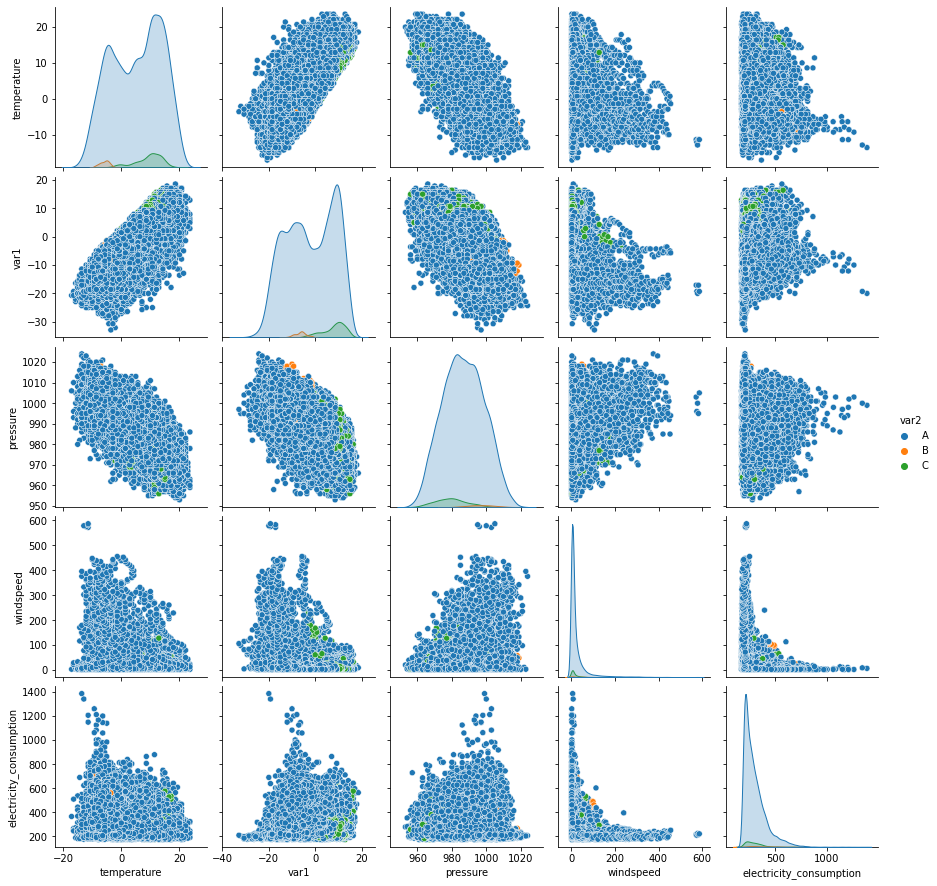

In [203]:
sns.pairplot(df.iloc[:,1:],hue='var2')

- There is no linear relationship is observed between independent and target features.
- There is no much data points w.r.t B and C in var2 feature. So it might not have much influence on target variable.

### Pearson's correlation coefficient 

<AxesSubplot:>

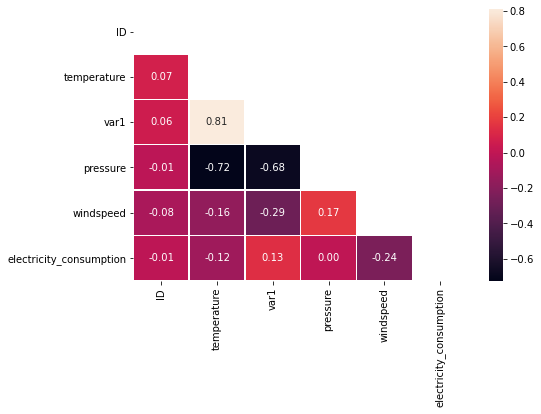

In [204]:
plt.figure(figsize=(7.5,5))
sns.heatmap(df.corr(),annot=True,fmt='.2F',linewidths=0.3,mask=np.triu(df.corr()))

- There is high correlation between pressure,temperature and var1.
- Pressure varibale could be dropped.

### Differentiating numerical and categorical features

In [205]:
df_num=df.select_dtypes('number')
y=df_num[['electricity_consumption']]
df_num=df_num.drop(['ID','electricity_consumption'],axis=1)
df_num.head()

,temperature,var1,pressure,windspeed
0,-11.4,-17.1,1003.0,571.910
1,-12.1,-19.3,996.0,575.040
2,-12.9,-20.0,1000.0,578.435
3,-11.4,-17.1,995.0,582.580
4,-11.4,-19.3,1005.0,586.600


In [206]:
df_date=df[['datetime']]
df_date.head()

,datetime
0,2013-07-01 00:00:00
1,2013-07-01 01:00:00
2,2013-07-01 02:00:00
3,2013-07-01 03:00:00
4,2013-07-01 04:00:00


In [207]:
df_cat=df.select_dtypes('object')
df_cat=df_cat.drop(['datetime'],axis=1)
df_cat.head()

,var2
0,A
1,A
2,A
3,A
4,A


### Scaling of numerical features

In [208]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
df_num=pd.DataFrame(scaler.fit_transform(df_num),index=df_num.index,columns=df_num.columns)
df_num.head()

,temperature,var1,pressure,windspeed
0,-1.900215,-1.456523,1.378837,11.349560
1,-1.980835,-1.667561,0.795622,11.414391
2,-2.072972,-1.734710,1.128888,11.484710
3,-1.900215,-1.456523,0.712305,11.570565
4,-1.900215,-1.667561,1.545470,11.653830


### Distribution plots

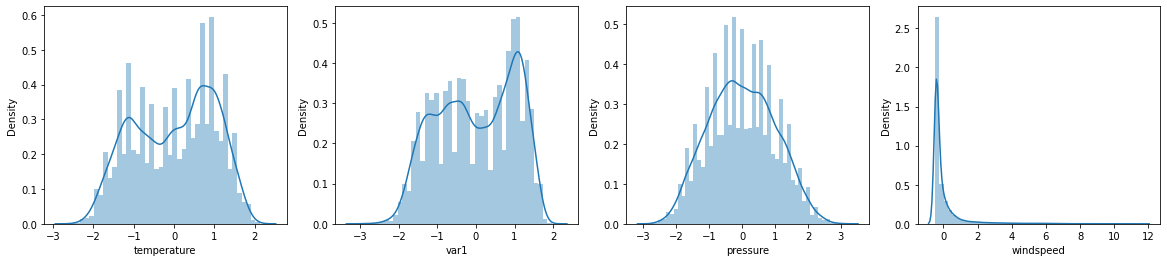

In [209]:
plt.figure(figsize=(20,4))
for i,col in enumerate(df_num):
    plt.subplot(1,4,i+1)
    sns.distplot(df_num[col])

### Boxplots plots for numerical features

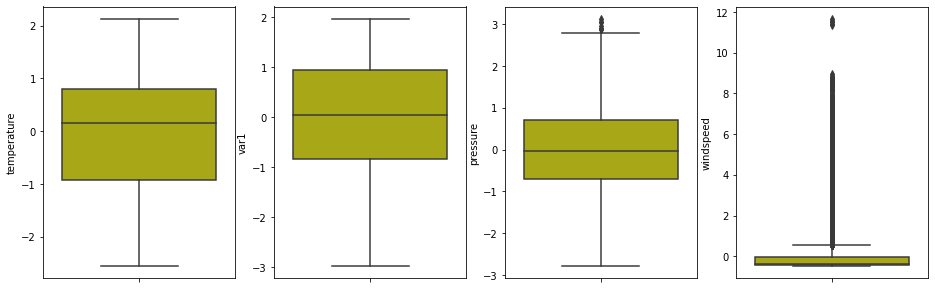

In [210]:
plt.figure(figsize=(20,5))
for i,col in enumerate(df_num):
    plt.subplot(1,5,i+1)
    sns.boxplot(y=df_num[col],color='y')

- As we observed in describe, windspeed have more outliers and is right skewed.

### Bi-variate analysis of categorical feature.

<AxesSubplot:xlabel='var2', ylabel='electricity_consumption'>

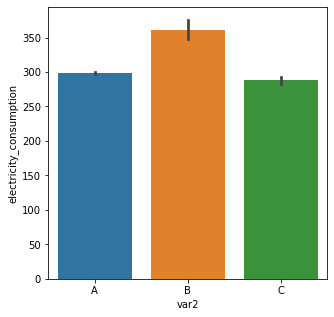

In [211]:
plt.figure(figsize=(5,5))
sns.barplot(df_cat['var2'],y['electricity_consumption'])

- var2 having value 'B' consumes more electricity and rest are almost equal.

### Encoding categorical variable using OneHotEncoder

In [212]:
df_cat=pd.get_dummies(df_cat,drop_first=True)
df_cat.head()

,var2_B,var2_C
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


### Feature extraction from datetime feature

- Extracting features out of datetime feature which will actually have influence on target feature.
- Features like year, month, day and hour at which observation is noted will be created.
- Dayofweek, weekend/weekday also influences as there might not be more consumption in weekends.
- Quarter and semester also might influence as there might be seasonal load shedding.   
So accordingly the features are extracted. 

In [213]:
df_date['Year']=pd.to_datetime(df_date['datetime']).dt.year
df_date['Month']=pd.to_datetime(df_date['datetime']).dt.month
df_date['Day']=pd.to_datetime(df_date['datetime']).dt.day
df_date['Dayofweek']=pd.to_datetime(df_date['datetime']).dt.dayofweek
df_date['Dayofyear']=pd.to_datetime(df_date['datetime']).dt.dayofyear
df_date['Week']=pd.to_datetime(df_date['datetime']).dt.week
df_date['Quarter']=pd.to_datetime(df_date['datetime']).dt.quarter
df_date['Semester']=np.where(df_date['Quarter'].isin([1,2]),1,2)
df_date['Is_weekend']=np.where(df_date['Dayofweek'].isin([5,6]),1,0)
df_date['Is_weekday']=np.where(~df_date['Dayofweek'].isin([5,6]),1,0)
df_date['Days_in_month']=pd.to_datetime(df_date['datetime']).dt.daysinmonth
df_date['Hour']=pd.to_datetime(df_date['datetime']).dt.hour
df_date.tail()

,datetime,Year,Month,Day,Dayofweek,Dayofyear,Week,Quarter,Semester,Is_weekend,Is_weekday,Days_in_month,Hour
26491,2017-06-23 19:00:00,2017,6,23,4,174,25,2,1,0,1,30,19
26492,2017-06-23 20:00:00,2017,6,23,4,174,25,2,1,0,1,30,20
26493,2017-06-23 21:00:00,2017,6,23,4,174,25,2,1,0,1,30,21
26494,2017-06-23 22:00:00,2017,6,23,4,174,25,2,1,0,1,30,22
26495,2017-06-23 23:00:00,2017,6,23,4,174,25,2,1,0,1,30,23


### Encoding Year feature using LabelEncoder

In [214]:
from sklearn.preprocessing import LabelEncoder
Label=LabelEncoder()
Label.fit_transform(df_date[['Year']])

array([0, 0, 0, ..., 4, 4, 4], dtype=int64)

In [215]:
df_date['Year']=Label.fit_transform(df_date[['Year']])
df_date.head()

,datetime,Year,Month,Day,Dayofweek,Dayofyear,Week,Quarter,Semester,Is_weekend,Is_weekday,Days_in_month,Hour
0,2013-07-01 00:00:00,0,7,1,0,182,27,3,2,0,1,31,0
1,2013-07-01 01:00:00,0,7,1,0,182,27,3,2,0,1,31,1
2,2013-07-01 02:00:00,0,7,1,0,182,27,3,2,0,1,31,2
3,2013-07-01 03:00:00,0,7,1,0,182,27,3,2,0,1,31,3
4,2013-07-01 04:00:00,0,7,1,0,182,27,3,2,0,1,31,4


### Concating all features into one DataFrame

In [216]:
df_fin=pd.concat([df_num,df_cat,df_date.iloc[:,1:],y],axis=1)
df_fin.head()

,temperature,var1,pressure,windspeed,var2_B,var2_C,Year,Month,Day,Dayofweek,Dayofyear,Week,Quarter,Semester,Is_weekend,Is_weekday,Days_in_month,Hour,electricity_consumption
0,-1.900215,-1.456523,1.378837,11.349560,0,0,0,7,1,0,182,27,3,2,0,1,31,0,216.0
1,-1.980835,-1.667561,0.795622,11.414391,0,0,0,7,1,0,182,27,3,2,0,1,31,1,210.0
2,-2.072972,-1.734710,1.128888,11.484710,0,0,0,7,1,0,182,27,3,2,0,1,31,2,225.0
3,-1.900215,-1.456523,0.712305,11.570565,0,0,0,7,1,0,182,27,3,2,0,1,31,3,216.0
4,-1.900215,-1.667561,1.545470,11.653830,0,0,0,7,1,0,182,27,3,2,0,1,31,4,222.0


### Dropping Features

- As pressure feature have high correlation with other features, it can be dropped.

In [217]:
df_fin=df_fin.drop(['pressure'],axis=1)

In [218]:
df_fin.shape

(26496, 18)

### Outlier treatment

- As there is high variation between 99 percentile and max value in windspeed, above 99 percentile observations are dropped.

In [219]:
df_fin=df_fin[df_fin['windspeed']<np.percentile(df_fin['windspeed'],99)]
df_fin.shape

(26231, 18)

In [220]:
df_fin.describe(percentiles=[0.01,0.1,0.25,0.5,0.75,0.9,0.99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
temperature,26231.0,0.010770,0.997153,-2.556693,-1.980835,-1.404977,-0.829119,0.149840,0.898455,1.220935,1.716173,2.130791
var1,26231.0,0.013701,0.994490,-2.972160,-1.936155,-1.389375,-0.842595,0.049520,0.941635,1.277378,1.622713,1.968047
windspeed,26231.0,-0.065145,0.756052,-0.474011,-0.464897,-0.449363,-0.430928,-0.364337,-0.052092,0.596011,3.680473,5.151369
var2_B,26231.0,0.008273,0.090579,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
var2_C,26231.0,0.039648,0.195134,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
Year,26231.0,2.003545,1.222060,0.000000,0.000000,0.000000,1.000000,2.000000,3.000000,4.000000,4.000000,4.000000
Month,26231.0,6.495597,3.465594,1.000000,1.000000,2.000000,3.000000,6.000000,10.000000,11.000000,12.000000,12.000000
Day,26231.0,12.016126,6.641441,1.000000,1.000000,3.000000,6.000000,12.000000,18.000000,21.000000,23.000000,23.000000
Dayofweek,26231.0,2.995120,2.003879,0.000000,0.000000,0.000000,1.000000,3.000000,5.000000,6.000000,6.000000,6.000000
Dayofyear,26231.0,178.596508,105.698972,1.000000,3.000000,36.000000,82.000000,174.000000,274.000000,323.000000,355.000000,358.000000


### Splitting data into test and train

In [221]:
from sklearn.model_selection import train_test_split
X=df_fin.drop(['electricity_consumption'],axis=1)
y=df_fin['electricity_consumption']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=4)

## Model Building 

### Randomforest Regression

#### Hyper Parameter tuning using GridSearchCV

In [222]:
'''from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer,r2_score,mean_absolute_error
params={'n_estimators':[50,100,200,500],
       'max_depth':[10,25,50,75,100],
       'min_samples_split':[5,10,20,25,50],
       'min_samples_leaf':[5,10,20,25,50],
       }
grid_RF=GridSearchCV(RandomForestRegressor(),params,scoring=make_scorer(r2_score),cv=5,n_jobs=-1,verbose=1)
grid_RF.fit(X_train,y_train)
print(grid_RF.best_score_)
print(grid_RF.best_estimator_)
RF_reg=grid_RF.best_estimator_'''

"from sklearn.model_selection import GridSearchCV\nfrom sklearn.ensemble import RandomForestRegressor\nfrom sklearn.metrics import make_scorer,r2_score,mean_absolute_error\nparams={'n_estimators':[50,100,200,500],\n       'max_depth':[10,25,50,75,100],\n       'min_samples_split':[5,10,20,25,50],\n       'min_samples_leaf':[5,10,20,25,50],\n       }\ngrid_RF=GridSearchCV(RandomForestRegressor(),params,scoring=make_scorer(mean_absolute_error),cv=5,n_jobs=-1,verbose=1)\ngrid_RF.fit(X_train,y_train)\nprint(grid_RF.best_score_)\nprint(grid_RF.best_estimator_)\nRF_reg=grid_RF.best_estimator_"

In [223]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer,r2_score,mean_absolute_error,mean_squared_error
RF_reg=RandomForestRegressor(n_estimators=50,max_depth=15,min_samples_split=5,
                            min_samples_leaf=5)
RF_reg.fit(X_train,y_train)

RandomForestRegressor(max_depth=15, min_samples_leaf=5, min_samples_split=5,
                      n_estimators=50)

#### Result print function

In [224]:
from sklearn.metrics import make_scorer,r2_score,mean_absolute_error,mean_squared_error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def result_print(reg,X_train,X_test,y_train,y_test):
    y_pred = reg.predict(X_train)
    y_pred1 = reg.predict(X_test)

    print('Train data evaluation:')
    print('R square score:', r2_score(y_train, y_pred))
    print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
    print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
    print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_train, y_pred))
    
    print('\nTest data evaluation:')
    print('R square score:', r2_score(y_test, y_pred1))
    print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred1))
    print('Mean Squared Error:', mean_squared_error(y_test, y_pred1))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred1)))
    print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_test, y_pred1))

#### Evaluation

In [225]:
result_print(RF_reg,X_train,X_test,y_train,y_test)

Train data evaluation:
R square score: 0.8574335895822316
Mean Absolute Error: 27.442074817464363
Mean Squared Error: 1674.0083012658254
Root Mean Squared Error: 40.91464653722216
Mean Absolute Percentage Error: 8.998478084198561

Test data evaluation:
R square score: 0.7297574530814674
Mean Absolute Error: 37.38288997747072
Mean Squared Error: 3112.3396398548307
Root Mean Squared Error: 55.788346810555616
Mean Absolute Percentage Error: 12.308369646247398


### Support Vector Machines

In [226]:
from sklearn.svm import SVR
SVM_reg=SVR(kernel='rbf',C=100,gamma=0.1)
SVM_reg.fit(X_train,y_train)

SVR(C=100, gamma=0.1)

#### Evaluation

In [227]:
result_print(SVM_reg,X_train,X_test,y_train,y_test)

Train data evaluation:
R square score: 0.7846045741029551
Mean Absolute Error: 23.074263845871364
Mean Squared Error: 2529.163285725835
Root Mean Squared Error: 50.29078728480829
Mean Absolute Percentage Error: 6.735917871129733

Test data evaluation:
R square score: 0.6643706342552614
Mean Absolute Error: 36.13587786386943
Mean Squared Error: 3865.3890411326997
Root Mean Squared Error: 62.17225298421073
Mean Absolute Percentage Error: 11.251706237731867


## Observations and Inference.

***
- Since the data points are taken at some instance of date and time, feature engineering is been done to extract meaningful data out of it.
- The features like windspeed and electricity_consumption are right skewed which needs otlier treatment.
- pressure feature is highly correlated with temperature and var1, so that feature needs to be dropped.
- Numerical features are in different scales, needs to be scaled.
- Categorical features needs to be encoded.
- Pairplots indicates there is no linear relationship between independent and target variables and it is scattered randomly.
- So Ensemble or some other algorithms needs to be build in order to have good predictions.
- Randomforestregressor with hyperparameter tuning is built with an MAPE of 8.9% on train data and 12.3% on test data.
- SVR with hyperparameter tuning is built with an MAPE of 6.7% on train data and 11.3% on test data.
***